In [47]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.optimizers import Adam
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [3]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [4]:
print('Loading word vectors...')
word2vec = {}

f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
f.close()

print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [37]:
print('Loading in comments...')

train = pd.read_csv("./toxic/train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [38]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


In [7]:
print("sequences:", sequences)

sequences: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 1400
min sequence length: 0
median sequence length: 35


In [39]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


Found 210337 unique tokens.


In [40]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


In [12]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [13]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [14]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Building model...


In [15]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 229s 2ms/step - loss: 0.0852 - acc: 0.9727 - val_loss: 0.0742 - val_acc: 0.9758
Epoch 2/10
127656/127656 [==============================] - 218s 2ms/step - loss: 0.0678 - acc: 0.9772 - val_loss: 0.0691 - val_acc: 0.9774
Epoch 3/10
127656/127656 [==============================] - 226s 2ms/step - loss: 0.0634 - acc: 0.9781 - val_loss: 0.0707 - val_acc: 0.9756
Epoch 4/10
127656/127656 [==============================] - 229s 2ms/step - loss: 0.0598 - acc: 0.9791 - val_loss: 0.0663 - val_acc: 0.9777
Epoch 5/10
127656/127656 [==============================] - 209s 2ms/step - loss: 0.0577 - acc: 0.9798 - val_loss: 0.0688 - val_acc: 0.97719s - loss: 0.0578 - ac - ETA: 7s - loss: 0.0578 - acc: 0.9 - ETA: 7s - loss: 0.0578 - acc: - ETA: 
Epoch 6/10
127656/127656 [==============================] - 201s 2ms/step - loss: 0.0558 - acc: 0.9801 - val_loss: 0.0730 - val_acc: 

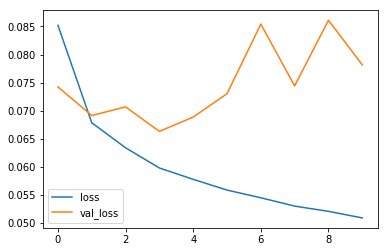

In [16]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()


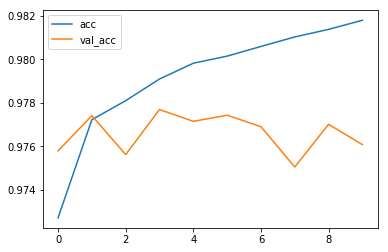

In [17]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [18]:
# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9747163737297672


In [48]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = Dropout(0.2)(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

Building model...


In [50]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=20,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/20
127656/127656 [==============================] - 281s 2ms/step - loss: 0.0579 - acc: 0.9798 - val_loss: 0.0582 - val_acc: 0.9803
Epoch 2/20
127656/127656 [==============================] - 297s 2ms/step - loss: 0.0531 - acc: 0.9810 - val_loss: 0.0549 - val_acc: 0.9811
Epoch 3/20
127656/127656 [==============================] - 274s 2ms/step - loss: 0.0511 - acc: 0.9816 - val_loss: 0.0533 - val_acc: 0.9810
Epoch 4/20
127656/127656 [==============================] - 233s 2ms/step - loss: 0.0504 - acc: 0.9818 - val_loss: 0.0529 - val_acc: 0.9813
Epoch 5/20
127656/127656 [==============================] - 242s 2ms/step - loss: 0.0494 - acc: 0.9820 - val_loss: 0.0528 - val_acc: 0.9812
Epoch 6/20
127656/127656 [==============================] - 259s 2ms/step - loss: 0.0480 - acc: 0.9825 - val_loss: 0.0513 - val_acc: 0.9814
Epoch 7/20
127656/127656 [==============================] - 239s 2ms/step - loss: 0.0472 - 

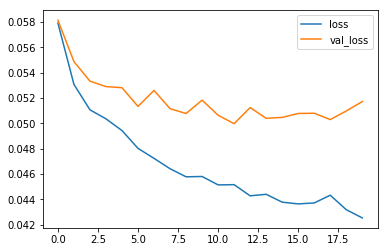

In [51]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

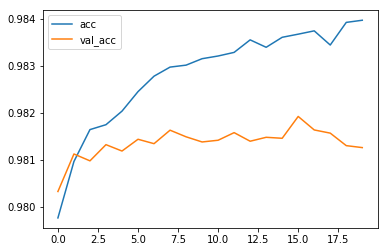

In [52]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [53]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9854269390438581


In [ ]:
print('Loading in comments...')

test = pd.read_csv("./toxic/test.csv")
sentences1 = test["comment_text"].fillna("DUMMY_VALUE").values
#possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
#targets = train[possible_labels].values

In [56]:
sentences1

array(["Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,",
       '== From RfC == \n\n The title is fine as it is, IMO.',
       '" \n\n == Sources == \n\n * Zawe Ashton on Lapland —  /  "', ...,
       '" \n\n == Okinotorishima categories == \n\n I see your changes and agree this is ""more correct.""  I had gotten confused, but then found this: \n :... while acknowledging Japan\'s territorial rights to Okinotorishima itself ... \n However, is there a category for  \n :... did not acknowledge Japan\'s claim to an exclusive economic zone (EEZ) stemming from Okinotorishima. \n That is, is there a category for ""disputed EEZ""s?   "',
       '" \n\n == ""One of the founding n

In [ ]:
#tokenizer.fit_on_texts(sentences1)
sequences1 = tokenizer.texts_to_sequences(sentences1)

In [ ]:
data1 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
p = model.predict(data1)

In [45]:
p

array([[9.9684685e-01, 5.0646293e-01, 9.9099874e-01, 6.3301936e-02,
        9.5762146e-01, 8.3827084e-01],
       [1.6838016e-03, 2.1579795e-05, 1.0199152e-03, 7.8107914e-06,
        3.1225124e-04, 4.6619659e-04],
       [9.8316313e-04, 5.2581472e-05, 7.9916813e-04, 3.1754636e-05,
        2.5833552e-04, 1.5471526e-04],
       ...,
       [8.7262527e-04, 3.2084634e-05, 6.4473058e-04, 1.8924361e-06,
        7.9393605e-05, 1.0136116e-04],
       [7.1700098e-04, 4.2314400e-06, 2.0119899e-04, 2.8457719e-06,
        9.5542200e-05, 1.2251799e-03],
       [9.7944427e-01, 6.2926032e-02, 7.9030210e-01, 1.1482131e-02,
        6.8545818e-01, 1.8807879e-02]], dtype=float32)

In [46]:
submission = pd.read_csv('./toxic/test_labels.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = p
submission.to_csv('./toxic/submission.csv', index=False)